In [1]:
!pip install keras-gym -U

# Project 2

In [2]:
import gym
import sys
import os
import time
import pandas
import random
import pickle
import itertools
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import keras_gym as km
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

/usr/local/lib/python3.7/dist-packages/keras_gym/base/patches.py:24: UserWarning: keras-gym has known issues with eager execution mode; eager execution has been disabled as a precaution. You may try and enable eager execution with: tf.compat.v1.enable_eager_execution()
  "keras-gym has known issues with eager execution mode; eager "


## APPROXIMATION FUNCTION

In [3]:
class LinearFunc2(km.FunctionApproximator):
    """ linear function approximator (body only does one-hot encoding) """
    pass

In [4]:
class LinearFunc(km.FunctionApproximator):
    """ linear function approximator (body only does one-hot encoding) """
    def body(self, S):
        one_hot_encoding = keras.layers.Lambda(lambda x: K.one_hot(x, 64))
        return one_hot_encoding(S)

In [5]:
class MLP(km.FunctionApproximator):
    """ multi-layer perceptron with one hidden layer """
    def body(self, S):
        one_hot_encoding = keras.layers.Lambda(lambda x: K.one_hot(x, 64))
        X = keras.layers.Flatten()(one_hot_encoding(S))
        X = keras.layers.Dense(units=64, activation='relu')(X)
        X = keras.layers.Dense(units=20, activation='relu')(X)
        X = keras.layers.Dense(units=4)(X)
        return X

## SAC

In [7]:
def sac_train(env, num_episodes=200, target_model_sync_period=10, lr=0.01, tau_=0.1, punishment=-0.1):
    #func = MLP(env, learning_rate=lr)
    func = LinearFunc2(env, learning_rate=lr)
    sac = km.SoftActorCritic.from_func(func)
    pi = sac.policy
    G = []

    for ep in range(num_episodes):
        s = env.reset()
        s_ant = s
        for t in itertools.count():
            a = pi(s)
            s_next, r, done, info = env.step(a)

            #Small incentive to keep moving
            if np.array_equal(s_next, s) or np.array_equal(s_next, s_ant):
                r = punishment

            #if t < 100:
            #    r += 0.05

            #if done and r==0:
            #    r = -0.5

            sac.update(s, a, r, done)

            if env.T % target_model_sync_period == 0:
                sac.sync_target_model(tau=tau_)

            if done:
                break
            
            s_ant =  s
            s = s_next
        G.append(env.G)

    return func, sac, pi, G

## TEST

In [8]:
def sac_test(env, sac, num_test=10, display=False):

  reward_global = 0
  for i in range(num_test):
    s = env.reset()

    if display:
      env.render()

    for t in itertools.count():

      if display:
        print(" v(s) = {:.3f}".format(sac.v_func(s)))

        for i, p in enumerate(km.utils.softmax(sac.policy.dist_params(s))):
          print(" pi({:s}|s) = {:.3f}".format(actions[i], p))

        for i, q in enumerate(sac.q_func1(s)):
          print(" q1(s,{:s}) = {:.3f}".format(actions[i], q))

        for i, q in enumerate(sac.q_func2(s)):
          print(" q2(s,{:s}) = {:.3f}".format(actions[i], q))

      a = sac.policy.greedy(s)
      s, r, done, info = env.step(a)

      if display:
        env.render()

      if done:
        reward_global += r
        break

  return reward_global/num_test

## SEARCH PARAMETERS

In [28]:
import time
import pandas
from sklearn.model_selection import ParameterGrid
import gc 

tbdir = datetime.datetime.now().strftime('data/tensorboard/%Y_%m_%d_%H')

def search_params(slippery=False, param=0):
  actions = ['L', 'S', 'R', 'N']

  if slippery:
    env = gym.make('FrozenLake8x8-v0', is_slippery=True)
    epi = 2000
  else:
    env = gym.make('FrozenLake8x8-v0', is_slippery=False)
    epi = 1000

  env = km.wrappers.TrainMonitor(env, tensorboard_dir=tbdir)
  km.enable_logging()

  if param ==0:
    param_ = {'target_model_sync_period': [10], 'episodes': [epi], 
              'lr': [0.005, 0.001], 'tau':[1.0], 'punishment':[-0.1]}
  elif param==1:
    param_ = {'target_model_sync_period': [5, 10, 25], 'episodes': [epi], 
              'lr': [0.005], 'tau':[1.0], 'punishment':[-0.1]}
  elif param==2:
    param_ = {'target_model_sync_period': [10], 'episodes': [epi], 
              'lr': [0.005], 'tau':[1.0, 0.9, 0.5], 'punishment':[-0.1]}  
  elif param==3:
    param_ = {'target_model_sync_period': [10], 'episodes': [epi], 
              'lr': [0.005], 'tau':[1.0], 'punishment':[-0.25,-0.1, -0.01]}    
  else:
    param_ = {'target_model_sync_period': [10], 'episodes': [epi], 
              'lr': [0.005], 'tau':[1.0, 0.5], 'punishment':[-0.25, -0.1, -0.01]}

  results = pandas.DataFrame(columns=[
                               'model_sync_period', 'episodes', 'lr', 'tau', 'punishment', 'reward_train', 'reward', 'elapsed time (s)'])
  
  for c in ParameterGrid(param_):
    print(c)
    if slippery:
      env = gym.make('FrozenLake8x8-v0', is_slippery=True)
    else:
      env = gym.make('FrozenLake8x8-v0', is_slippery=False)

    gc.collect()  #clean memory form coolab
    np.random.seed(2) 
    tf.random.set_seed(2)
    env.seed(2) 
    keras.backend.clear_session()

    env = km.wrappers.TrainMonitor(env, tensorboard_dir=tbdir)
    km.enable_logging()

    model_syn_period= c['target_model_sync_period']
    episodes        = c['episodes']
    lr              = c['lr']
    tau_            = c['tau']
    punishment      = c['punishment']
    

    tic = time.time()
    func, sac, pi, Reward = sac_train(env, episodes , model_syn_period, lr, tau_, punishment)
    toc = time.time()
    
    elapsed_time = toc - tic

    scores = sac_test(env, sac, num_test=50, display=False)

    new_row = {'model_sync_period': c['target_model_sync_period'],
               'episodes'       : c['episodes'],
               'lr'             : c['lr'],
               'tau'            : c['tau'],
               'punishment'     : c['punishment'],
               'reward_train'   : (np.array(Reward).sum()/episodes)*100,
               'reward'         : scores*100,
               'elapsed time (s)': elapsed_time}

    results = results.append(new_row, ignore_index=True)

    print("result: ", scores*100, (np.array(Reward).sum()/episodes)*100)

  return results

## RESULTS

In [10]:
result = search_params(False, 0)

{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 1.0}


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
INFO:TrainMonitor:ep: 1, T: 33, G: 0, avg_G: 0, t: 32, dt: 58.883ms, loss: 0.00989, policy/entropy: 1.39, policy/loss: 0.0052, v_func/loss: 0.000261, q_func1/loss: 0.00163, q_func2/loss: 0.00163, value/loss: 0.00117
INFO:TrainMonitor:ep: 2, T: 43, G: 0, avg_G: 0, t: 9, dt: 13.377ms, loss: 0.00649, policy/entropy: 1.39, policy/loss: 0.00224, v_func/loss: 0.000316, q_func1/loss: 0.00144, q_func2/loss: 0.00144, value/loss: 0.00106
INFO:TrainMonitor:ep: 3, T: 57, G: 0, avg_G: 0, t: 13, dt: 14.144ms, loss: 0.00753, policy/entropy: 1.39, policy/loss: 0.00357, v_func/loss: 0.00041, q_func1/loss: 0.00128, q_func2/loss: 0.00128, value/loss: 0.000988
INFO:TrainMonitor:ep: 4, T: 65, G: 0, avg_G: 0, t: 7, dt: 12.058ms, loss: 0.00734, p

result:  100.0 31.8
{'episodes': 1000, 'lr': 0.001, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 29, G: 0, avg_G: 0, t: 28, dt: 65.262ms, loss: 0.00208, policy/entropy: 1.39, policy/loss: -0.00258, v_func/loss: 2.17e-05, q_func1/loss: 0.00173, q_func2/loss: 0.00173, value/loss: 0.00116
INFO:TrainMonitor:ep: 2, T: 37, G: 0, avg_G: 0, t: 7, dt: 11.138ms, loss: 0.00387, policy/entropy: 1.39, policy/loss: -0.000133, v_func/loss: 3.56e-05, q_func1/loss: 0.00148, q_func2/loss: 0.00148, value/loss: 0.001
INFO:TrainMonitor:ep: 3, T: 55, G: 0, avg_G: 0, t: 17, dt: 14.233ms, loss: 0.00401, policy/entropy: 1.39, policy/loss: -9.76e-05, v_func/loss: 2.77e-05, q_func1/loss: 0.00153, q_func2/loss: 0.00153, value/loss: 0.00103
INFO:TrainMonitor:ep: 4, T: 82, G: 0, avg_G: 0, t: 26, dt: 14.696ms, loss: 0.00405, policy/entropy: 1.39, policy/loss: 0.000448, v_func/loss: 3.5e-05, q_func1/loss: 0.00133, q_func2/loss: 0.00133, value/loss: 0.000901
INFO:TrainMonitor:ep: 5, T: 92, G: 0, avg_G: 0, t: 9, dt: 14.329ms, loss: 0.00432, policy/entropy: 1.39, policy/loss: 0.000683, v

result:  0.0 2.3


In [12]:
result

model_sync_period  episodes     lr  ...  reward_train  reward  elapsed time (s)
0               10.0    1000.0  0.005  ...          31.8   100.0        171.727579
1               10.0    1000.0  0.001  ...           2.3     0.0        151.158258

[2 rows x 8 columns]

In [14]:
result = search_params(False, 1)

{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 5, 'tau': 1.0}


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
INFO:TrainMonitor:ep: 1, T: 15, G: 0, avg_G: 0, t: 14, dt: 121.102ms, loss: 0.00636, policy/entropy: 1.39, policy/loss: 0.0018, v_func/loss: 0.0001, q_func1/loss: 0.00166, q_func2/loss: 0.00166, value/loss: 0.00114
INFO:TrainMonitor:ep: 2, T: 32, G: 0, avg_G: 0, t: 16, dt: 14.707ms, loss: 0.00406, policy/entropy: 1.39, policy/loss: 4.14e-05, v_func/loss: 0.00021, q_func1/loss: 0.0014, q_func2/loss: 0.0014, value/loss: 0.00101
INFO:TrainMonitor:ep: 3, T: 77, G: 0, avg_G: 0, t: 44, dt: 15.915ms, loss: 0.00453, policy/entropy: 1.38, policy/loss: 0.000676, v_func/loss: 0.00039, q_func1/loss: 0.00125, q_func2/loss: 0.00125, value/loss: 0.000963
INFO:TrainMonitor:ep: 4, T: 127, G: 0, avg_G: 0, t: 49, dt: 15.804ms, loss: 0.00555, 

result:  0.0 2.9000000000000004
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 19, G: 0, avg_G: 0, t: 18, dt: 94.514ms, loss: 0.00532, policy/entropy: 1.39, policy/loss: 0.000845, v_func/loss: 6.55e-05, q_func1/loss: 0.00165, q_func2/loss: 0.00165, value/loss: 0.00112
INFO:TrainMonitor:ep: 2, T: 49, G: 0, avg_G: 0, t: 29, dt: 14.392ms, loss: 0.00429, policy/entropy: 1.39, policy/loss: -7.05e-05, v_func/loss: 0.000242, q_func1/loss: 0.00152, q_func2/loss: 0.00152, value/loss: 0.00109
INFO:TrainMonitor:ep: 3, T: 70, G: 0, avg_G: 0, t: 20, dt: 14.110ms, loss: 0.00604, policy/entropy: 1.38, policy/loss: 0.00215, v_func/loss: 0.000257, q_func1/loss: 0.00133, q_func2/loss: 0.00133, value/loss: 0.000972
INFO:TrainMonitor:ep: 4, T: 107, G: 0, avg_G: 0, t: 36, dt: 14.993ms, loss: 0.00644, policy/entropy: 1.38, policy/loss: 0.00186, v_func/loss: 0.000306, q_func1/loss: 0.00157, q_func2/loss: 0.00157, value/loss: 0.00115
INFO:TrainMonitor:ep: 5, T: 118, G: 0, avg_G: 0, t: 10, dt: 12.735ms, loss: 0.00859, policy/entropy: 1.38, policy/loss: 0.00402

result:  100.0 14.000000000000002
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 25, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 30, G: 0, avg_G: 0, t: 29, dt: 65.281ms, loss: 0.00206, policy/entropy: 1.39, policy/loss: -0.00163, v_func/loss: 9.35e-05, q_func1/loss: 0.00134, q_func2/loss: 0.00134, value/loss: 0.000924
INFO:TrainMonitor:ep: 2, T: 49, G: 0, avg_G: 0, t: 18, dt: 13.290ms, loss: 0.00605, policy/entropy: 1.38, policy/loss: 0.00249, v_func/loss: 0.000165, q_func1/loss: 0.00125, q_func2/loss: 0.00125, value/loss: 0.000889
INFO:TrainMonitor:ep: 3, T: 71, G: 0, avg_G: 0, t: 21, dt: 13.790ms, loss: 0.00211, policy/entropy: 1.38, policy/loss: -0.00144, v_func/loss: 0.000283, q_func1/loss: 0.00119, q_func2/loss: 0.00119, value/loss: 0.000885
INFO:TrainMonitor:ep: 4, T: 83, G: 0, avg_G: 0, t: 11, dt: 13.786ms, loss: 0.00192, policy/entropy: 1.38, policy/loss: -0.00149, v_func/loss: 0.000437, q_func1/loss: 0.00106, q_func2/loss: 0.00106, value/loss: 0.00085
INFO:TrainMonitor:ep: 5, T: 130, G: 0, avg_G: 0, t: 46, dt: 15.346ms, loss: 0.00675, policy/entropy: 1.38, policy/loss: 0.0030

result:  0.0 2.9000000000000004


In [15]:
result

model_sync_period  episodes     lr  ...  reward_train  reward  elapsed time (s)
0                5.0    1000.0  0.005  ...           2.9     0.0        147.153625
1               10.0    1000.0  0.005  ...          14.0   100.0        155.670499
2               25.0    1000.0  0.005  ...           2.9     0.0        137.243105

[3 rows x 8 columns]

In [17]:
result = search_params(False, 2)

{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 1.0}


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
INFO:TrainMonitor:ep: 1, T: 16, G: 0, avg_G: 0, t: 15, dt: 113.408ms, loss: 0.00425, policy/entropy: 1.39, policy/loss: 0.00356, v_func/loss: 8.75e-05, q_func1/loss: 0.000217, q_func2/loss: 0.000217, value/loss: 0.000174
INFO:TrainMonitor:ep: 2, T: 59, G: 0, avg_G: 0, t: 42, dt: 14.995ms, loss: 0.00551, policy/entropy: 1.38, policy/loss: 0.00272, v_func/loss: 0.000244, q_func1/loss: 0.000923, q_func2/loss: 0.000923, value/loss: 0.000697
INFO:TrainMonitor:ep: 3, T: 81, G: 0, avg_G: 0, t: 21, dt: 14.598ms, loss: 0.00753, policy/entropy: 1.38, policy/loss: 0.00418, v_func/loss: 0.000376, q_func1/loss: 0.00107, q_func2/loss: 0.00107, value/loss: 0.000838
INFO:TrainMonitor:ep: 4, T: 111, G: 0, avg_G: 0, t: 29, dt: 14.639ms, loss

result:  100.0 24.8
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 0.9}


INFO:TrainMonitor:ep: 1, T: 30, G: 0, avg_G: 0, t: 29, dt: 65.351ms, loss: 0.00701, policy/entropy: 1.39, policy/loss: 0.00252, v_func/loss: 0.000122, q_func1/loss: 0.00162, q_func2/loss: 0.00162, value/loss: 0.00112
INFO:TrainMonitor:ep: 2, T: 42, G: 0, avg_G: 0, t: 11, dt: 14.450ms, loss: 0.00468, policy/entropy: 1.39, policy/loss: 0.00062, v_func/loss: 0.000133, q_func1/loss: 0.00145, q_func2/loss: 0.00145, value/loss: 0.00101
INFO:TrainMonitor:ep: 3, T: 52, G: 0, avg_G: 0, t: 9, dt: 13.801ms, loss: 0.00905, policy/entropy: 1.39, policy/loss: 0.00512, v_func/loss: 0.000248, q_func1/loss: 0.00135, q_func2/loss: 0.00135, value/loss: 0.000983
INFO:TrainMonitor:ep: 4, T: 67, G: 0, avg_G: 0, t: 14, dt: 13.470ms, loss: 0.00676, policy/entropy: 1.39, policy/loss: 0.00281, v_func/loss: 0.000365, q_func1/loss: 0.0013, q_func2/loss: 0.0013, value/loss: 0.000989
INFO:TrainMonitor:ep: 5, T: 84, G: 0, avg_G: 0, t: 16, dt: 13.849ms, loss: 0.00857, policy/entropy: 1.38, policy/loss: 0.00443, v_fun

result:  0.0 1.6
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 0.5}


INFO:TrainMonitor:ep: 1, T: 21, G: 0, avg_G: 0, t: 20, dt: 86.712ms, loss: 0.00481, policy/entropy: 1.39, policy/loss: 3.38e-05, v_func/loss: 0.000215, q_func1/loss: 0.00168, q_func2/loss: 0.00168, value/loss: 0.00119
INFO:TrainMonitor:ep: 2, T: 56, G: 0, avg_G: 0, t: 34, dt: 14.578ms, loss: 0.00813, policy/entropy: 1.39, policy/loss: 0.00386, v_func/loss: 0.000249, q_func1/loss: 0.00148, q_func2/loss: 0.00148, value/loss: 0.00107
INFO:TrainMonitor:ep: 3, T: 68, G: 0, avg_G: 0, t: 11, dt: 12.777ms, loss: 0.00587, policy/entropy: 1.39, policy/loss: 0.00159, v_func/loss: 0.00036, q_func1/loss: 0.00143, q_func2/loss: 0.00143, value/loss: 0.00107
INFO:TrainMonitor:ep: 4, T: 94, G: 0, avg_G: 0, t: 25, dt: 14.564ms, loss: 0.00715, policy/entropy: 1.38, policy/loss: 0.00298, v_func/loss: 0.000432, q_func1/loss: 0.00135, q_func2/loss: 0.00135, value/loss: 0.00104
INFO:TrainMonitor:ep: 5, T: 130, G: 0, avg_G: 0, t: 35, dt: 14.128ms, loss: 0.00658, policy/entropy: 1.38, policy/loss: 0.00252, v_f

result:  100.0 26.400000000000002


In [18]:
result

model_sync_period  episodes     lr  ...  reward_train  reward  elapsed time (s)
0               10.0    1000.0  0.005  ...          24.8   100.0        164.551943
1               10.0    1000.0  0.005  ...           1.6     0.0        134.547454
2               10.0    1000.0  0.005  ...          26.4   100.0        169.096421

[3 rows x 8 columns]

In [20]:
result = search_params(False, 3)

{'episodes': 1000, 'lr': 0.005, 'punishment': -0.25, 'target_model_sync_period': 10, 'tau': 1.0}


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
INFO:TrainMonitor:ep: 1, T: 21, G: 0, avg_G: 0, t: 20, dt: 87.160ms, loss: 0.0293, policy/entropy: 1.39, policy/loss: 0.00184, v_func/loss: 9.11e-05, q_func1/loss: 0.0103, q_func2/loss: 0.0103, value/loss: 0.00687
INFO:TrainMonitor:ep: 2, T: 65, G: 0, avg_G: 0, t: 43, dt: 14.547ms, loss: 0.025, policy/entropy: 1.38, policy/loss: 0.0019, v_func/loss: 0.000346, q_func1/loss: 0.0085, q_func2/loss: 0.0085, value/loss: 0.00578
INFO:TrainMonitor:ep: 3, T: 96, G: 0, avg_G: 0, t: 30, dt: 14.440ms, loss: 0.0249, policy/entropy: 1.38, policy/loss: 0.00151, v_func/loss: 0.000739, q_func1/loss: 0.00841, q_func2/loss: 0.00841, value/loss: 0.00585
INFO:TrainMonitor:ep: 4, T: 117, G: 0, avg_G: 0, t: 20, dt: 14.579ms, loss: 0.0325, policy/

result:  100.0 6.3
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 82, G: 0, avg_G: 0, t: 81, dt: 34.194ms, loss: 0.00859, policy/entropy: 1.38, policy/loss: 0.00468, v_func/loss: 0.000404, q_func1/loss: 0.00126, q_func2/loss: 0.00126, value/loss: 0.000978
INFO:TrainMonitor:ep: 2, T: 108, G: 0, avg_G: 0, t: 25, dt: 14.600ms, loss: 0.00737, policy/entropy: 1.38, policy/loss: 0.00332, v_func/loss: 0.000504, q_func1/loss: 0.00127, q_func2/loss: 0.00127, value/loss: 0.00101
INFO:TrainMonitor:ep: 3, T: 123, G: 0, avg_G: 0, t: 14, dt: 14.152ms, loss: 0.00828, policy/entropy: 1.38, policy/loss: 0.00404, v_func/loss: 0.000538, q_func1/loss: 0.00132, q_func2/loss: 0.00132, value/loss: 0.00106
INFO:TrainMonitor:ep: 4, T: 135, G: 0, avg_G: 0, t: 11, dt: 13.285ms, loss: 0.0095, policy/entropy: 1.38, policy/loss: 0.00523, v_func/loss: 0.000583, q_func1/loss: 0.00131, q_func2/loss: 0.00131, value/loss: 0.00107
INFO:TrainMonitor:ep: 5, T: 150, G: 0, avg_G: 0, t: 14, dt: 14.106ms, loss: 0.00821, policy/entropy: 1.38, policy/loss: 0.00369, 

result:  100.0 38.800000000000004
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.01, 'target_model_sync_period': 10, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 17, G: 0, avg_G: 0, t: 16, dt: 101.313ms, loss: 0.00401, policy/entropy: 1.39, policy/loss: 0.00357, v_func/loss: 0.000122, q_func1/loss: 0.000104, q_func2/loss: 0.000104, value/loss: 0.00011
INFO:TrainMonitor:ep: 2, T: 45, G: 0, avg_G: 0, t: 27, dt: 14.672ms, loss: 0.000309, policy/entropy: 1.39, policy/loss: -0.000446, v_func/loss: 0.000209, q_func1/loss: 0.000179, q_func2/loss: 0.000179, value/loss: 0.000189
INFO:TrainMonitor:ep: 3, T: 60, G: 0, avg_G: 0, t: 14, dt: 12.739ms, loss: -0.00299, policy/entropy: 1.39, policy/loss: -0.00383, v_func/loss: 0.000244, q_func1/loss: 0.000195, q_func2/loss: 0.000195, value/loss: 0.000211
INFO:TrainMonitor:ep: 4, T: 80, G: 0, avg_G: 0, t: 19, dt: 14.011ms, loss: -0.00134, policy/entropy: 1.39, policy/loss: -0.00217, v_func/loss: 0.000211, q_func1/loss: 0.000207, q_func2/loss: 0.000207, value/loss: 0.000208
INFO:TrainMonitor:ep: 5, T: 108, G: 0, avg_G: 0, t: 27, dt: 14.366ms, loss: 0.000323, policy/entropy: 1.38, polic

result:  100.0 40.0


In [22]:
result

model_sync_period  episodes     lr  ...  reward_train  reward  elapsed time (s)
0               10.0    1000.0  0.005  ...           6.3   100.0        134.070467
1               10.0    1000.0  0.005  ...          38.8   100.0        179.723277
2               10.0    1000.0  0.005  ...          40.0   100.0        596.497628

[3 rows x 8 columns]

In [24]:
result = search_params(False, 6)

{'episodes': 1000, 'lr': 0.005, 'punishment': -0.25, 'target_model_sync_period': 10, 'tau': 1.0}


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
INFO:TrainMonitor:ep: 1, T: 23, G: 0, avg_G: 0, t: 22, dt: 84.098ms, loss: 0.028, policy/entropy: 1.39, policy/loss: 0.000811, v_func/loss: 9.46e-05, q_func1/loss: 0.0102, q_func2/loss: 0.0102, value/loss: 0.0068
INFO:TrainMonitor:ep: 2, T: 37, G: 0, avg_G: 0, t: 13, dt: 12.951ms, loss: 0.0253, policy/entropy: 1.39, policy/loss: -0.00119, v_func/loss: 0.000141, q_func1/loss: 0.00987, q_func2/loss: 0.00987, value/loss: 0.00663
INFO:TrainMonitor:ep: 3, T: 106, G: 0, avg_G: 0, t: 68, dt: 15.096ms, loss: 0.0297, policy/entropy: 1.38, policy/loss: 0.0054, v_func/loss: 0.001, q_func1/loss: 0.0086, q_func2/loss: 0.0086, value/loss: 0.00607
INFO:TrainMonitor:ep: 4, T: 126, G: 0, avg_G: 0, t: 19, dt: 14.384ms, loss: 0.0349, policy/e

result:  0.0 2.1999999999999997
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.25, 'target_model_sync_period': 10, 'tau': 0.5}


INFO:TrainMonitor:ep: 1, T: 26, G: 0, avg_G: 0, t: 25, dt: 73.565ms, loss: 0.0391, policy/entropy: 1.39, policy/loss: 0.000839, v_func/loss: 0.000102, q_func1/loss: 0.0143, q_func2/loss: 0.0143, value/loss: 0.00956
INFO:TrainMonitor:ep: 2, T: 58, G: 0, avg_G: 0, t: 31, dt: 14.661ms, loss: 0.0339, policy/entropy: 1.38, policy/loss: 0.00664, v_func/loss: 0.000491, q_func1/loss: 0.00996, q_func2/loss: 0.00996, value/loss: 0.0068
INFO:TrainMonitor:ep: 3, T: 70, G: 0, avg_G: 0, t: 11, dt: 13.023ms, loss: 0.0276, policy/entropy: 1.38, policy/loss: 0.00263, v_func/loss: 0.000625, q_func1/loss: 0.00907, q_func2/loss: 0.00907, value/loss: 0.00625
INFO:TrainMonitor:ep: 4, T: 111, G: 0, avg_G: 0, t: 40, dt: 14.955ms, loss: 0.0329, policy/entropy: 1.38, policy/loss: 0.00739, v_func/loss: 0.000914, q_func1/loss: 0.00911, q_func2/loss: 0.00911, value/loss: 0.00638
INFO:TrainMonitor:ep: 5, T: 123, G: 0, avg_G: 0, t: 11, dt: 13.262ms, loss: 0.0317, policy/entropy: 1.37, policy/loss: 0.0075, v_func/los

result:  0.0 1.2
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 59, G: 0, avg_G: 0, t: 58, dt: 40.682ms, loss: 0.00533, policy/entropy: 1.39, policy/loss: 0.00134, v_func/loss: 0.00023, q_func1/loss: 0.00138, q_func2/loss: 0.00138, value/loss: 0.000998
INFO:TrainMonitor:ep: 2, T: 99, G: 0, avg_G: 0, t: 39, dt: 14.582ms, loss: 0.00643, policy/entropy: 1.38, policy/loss: 0.00195, v_func/loss: 0.000604, q_func1/loss: 0.00138, q_func2/loss: 0.00138, value/loss: 0.00112
INFO:TrainMonitor:ep: 3, T: 161, G: 0, avg_G: 0, t: 61, dt: 15.352ms, loss: 0.00543, policy/entropy: 1.38, policy/loss: 0.000715, v_func/loss: 0.000938, q_func1/loss: 0.0013, q_func2/loss: 0.0013, value/loss: 0.00118
INFO:TrainMonitor:ep: 4, T: 191, G: 0, avg_G: 0, t: 29, dt: 14.850ms, loss: 0.00665, policy/entropy: 1.38, policy/loss: 0.0017, v_func/loss: 0.000936, q_func1/loss: 0.00139, q_func2/loss: 0.00139, value/loss: 0.00124
INFO:TrainMonitor:ep: 5, T: 224, G: 0, avg_G: 0, t: 32, dt: 14.791ms, loss: 0.00664, policy/entropy: 1.38, policy/loss: 0.00139, v_f

result:  100.0 24.9
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 0.5}


INFO:TrainMonitor:ep: 1, T: 15, G: 0, avg_G: 0, t: 14, dt: 117.966ms, loss: 0.00635, policy/entropy: 1.39, policy/loss: 0.00148, v_func/loss: 7.31e-05, q_func1/loss: 0.00179, q_func2/loss: 0.00179, value/loss: 0.00122
INFO:TrainMonitor:ep: 2, T: 43, G: 0, avg_G: 0, t: 27, dt: 14.353ms, loss: 0.0078, policy/entropy: 1.39, policy/loss: 0.00406, v_func/loss: 0.000236, q_func1/loss: 0.00128, q_func2/loss: 0.00128, value/loss: 0.000935
INFO:TrainMonitor:ep: 3, T: 78, G: 0, avg_G: 0, t: 34, dt: 14.612ms, loss: 0.0086, policy/entropy: 1.38, policy/loss: 0.00511, v_func/loss: 0.000571, q_func1/loss: 0.00102, q_func2/loss: 0.00102, value/loss: 0.000873
INFO:TrainMonitor:ep: 4, T: 92, G: 0, avg_G: 0, t: 13, dt: 14.045ms, loss: 0.00582, policy/entropy: 1.38, policy/loss: 0.00203, v_func/loss: 0.000715, q_func1/loss: 0.00106, q_func2/loss: 0.00106, value/loss: 0.000947
INFO:TrainMonitor:ep: 5, T: 102, G: 0, avg_G: 0, t: 9, dt: 12.935ms, loss: 0.00834, policy/entropy: 1.38, policy/loss: 0.00449, v_

result:  100.0 37.6
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.01, 'target_model_sync_period': 10, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 42, G: 0, avg_G: 0, t: 41, dt: 50.833ms, loss: -1.4e-05, policy/entropy: 1.39, policy/loss: -0.000428, v_func/loss: 8.51e-05, q_func1/loss: 0.000113, q_func2/loss: 0.000113, value/loss: 0.000103
INFO:TrainMonitor:ep: 2, T: 61, G: 0, avg_G: 0, t: 18, dt: 13.933ms, loss: -0.0019, policy/entropy: 1.39, policy/loss: -0.00238, v_func/loss: 0.000129, q_func1/loss: 0.000116, q_func2/loss: 0.000116, value/loss: 0.00012
INFO:TrainMonitor:ep: 3, T: 86, G: 0, avg_G: 0, t: 24, dt: 14.367ms, loss: 2.54e-05, policy/entropy: 1.39, policy/loss: -0.00086, v_func/loss: 0.000232, q_func1/loss: 0.000216, q_func2/loss: 0.000216, value/loss: 0.000221
INFO:TrainMonitor:ep: 4, T: 139, G: 0, avg_G: 0, t: 52, dt: 14.973ms, loss: -0.000327, policy/entropy: 1.38, policy/loss: -0.00161, v_func/loss: 0.000327, q_func1/loss: 0.000319, q_func2/loss: 0.000319, value/loss: 0.000322
INFO:TrainMonitor:ep: 5, T: 183, G: 0, avg_G: 0, t: 43, dt: 14.741ms, loss: 0.00252, policy/entropy: 1.38, poli

result:  100.0 60.3
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.01, 'target_model_sync_period': 10, 'tau': 0.5}


INFO:TrainMonitor:ep: 1, T: 51, G: 0, avg_G: 0, t: 50, dt: 44.206ms, loss: 0.000868, policy/entropy: 1.39, policy/loss: 0.000398, v_func/loss: 0.000161, q_func1/loss: 9.57e-05, q_func2/loss: 9.57e-05, value/loss: 0.000117
INFO:TrainMonitor:ep: 2, T: 76, G: 0, avg_G: 0, t: 24, dt: 14.033ms, loss: -0.00201, policy/entropy: 1.38, policy/loss: -0.00267, v_func/loss: 0.000188, q_func1/loss: 0.000154, q_func2/loss: 0.000154, value/loss: 0.000165
INFO:TrainMonitor:ep: 3, T: 106, G: 0, avg_G: 0, t: 29, dt: 14.369ms, loss: 0.000582, policy/entropy: 1.38, policy/loss: -0.000396, v_func/loss: 0.000235, q_func1/loss: 0.000249, q_func2/loss: 0.000249, value/loss: 0.000245
INFO:TrainMonitor:ep: 4, T: 136, G: 0, avg_G: 0, t: 29, dt: 14.381ms, loss: 0.000475, policy/entropy: 1.38, policy/loss: -0.00047, v_func/loss: 0.000249, q_func1/loss: 0.00023, q_func2/loss: 0.00023, value/loss: 0.000236
INFO:TrainMonitor:ep: 5, T: 154, G: 0, avg_G: 0, t: 17, dt: 14.373ms, loss: 0.00199, policy/entropy: 1.38, poli

result:  0.0 0.1


In [25]:
result

model_sync_period  episodes     lr  ...  reward_train  reward  elapsed time (s)
0               10.0    1000.0  0.005  ...           2.2     0.0        123.896235
1               10.0    1000.0  0.005  ...           1.2     0.0        120.049838
2               10.0    1000.0  0.005  ...          24.9   100.0        170.929226
3               10.0    1000.0  0.005  ...          37.6   100.0        182.357239
4               10.0    1000.0  0.005  ...          60.3   100.0        649.997202
5               10.0    1000.0  0.005  ...           0.1     0.0       1901.403648

[6 rows x 8 columns]

In [26]:
result = search_params(True, 6)

{'episodes': 1000, 'lr': 0.005, 'punishment': -0.25, 'target_model_sync_period': 10, 'tau': 1.0}


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
INFO:TrainMonitor:ep: 1, T: 20, G: 0, avg_G: 0, t: 19, dt: 91.690ms, loss: 0.0295, policy/entropy: 1.39, policy/loss: 0.000834, v_func/loss: 6.33e-05, q_func1/loss: 0.0107, q_func2/loss: 0.0107, value/loss: 0.00716
INFO:TrainMonitor:ep: 2, T: 73, G: 0, avg_G: 0, t: 52, dt: 14.759ms, loss: 0.0352, policy/entropy: 1.38, policy/loss: 0.00413, v_func/loss: 0.000255, q_func1/loss: 0.0115, q_func2/loss: 0.0115, value/loss: 0.00776
INFO:TrainMonitor:ep: 3, T: 92, G: 0, avg_G: 0, t: 18, dt: 14.512ms, loss: 0.0352, policy/entropy: 1.38, policy/loss: 0.00345, v_func/loss: 0.000362, q_func1/loss: 0.0117, q_func2/loss: 0.0117, value/loss: 0.00794
INFO:TrainMonitor:ep: 4, T: 112, G: 0, avg_G: 0, t: 19, dt: 14.090ms, loss: 0.0363, policy

result:  0.0 0.7000000000000001
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.25, 'target_model_sync_period': 10, 'tau': 0.5}


INFO:TrainMonitor:ep: 1, T: 40, G: 0, avg_G: 0, t: 39, dt: 50.896ms, loss: 0.0509, policy/entropy: 1.38, policy/loss: 0.00484, v_func/loss: 0.000396, q_func1/loss: 0.0171, q_func2/loss: 0.0171, value/loss: 0.0115
INFO:TrainMonitor:ep: 2, T: 74, G: 0, avg_G: 0, t: 33, dt: 14.522ms, loss: 0.0409, policy/entropy: 1.38, policy/loss: 0.00303, v_func/loss: 0.000589, q_func1/loss: 0.0139, q_func2/loss: 0.0139, value/loss: 0.00947
INFO:TrainMonitor:ep: 3, T: 95, G: 0, avg_G: 0, t: 20, dt: 13.978ms, loss: 0.0379, policy/entropy: 1.38, policy/loss: 0.00568, v_func/loss: 0.000575, q_func1/loss: 0.0118, q_func2/loss: 0.0118, value/loss: 0.00804
INFO:TrainMonitor:ep: 4, T: 109, G: 0, avg_G: 0, t: 13, dt: 13.373ms, loss: 0.0377, policy/entropy: 1.38, policy/loss: 0.00538, v_func/loss: 0.000566, q_func1/loss: 0.0119, q_func2/loss: 0.0119, value/loss: 0.00809
INFO:TrainMonitor:ep: 5, T: 133, G: 0, avg_G: 0, t: 23, dt: 14.439ms, loss: 0.0349, policy/entropy: 1.37, policy/loss: 0.00469, v_func/loss: 0.0

result:  0.0 0.4
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 25, G: 0, avg_G: 0, t: 24, dt: 75.117ms, loss: 0.0102, policy/entropy: 1.39, policy/loss: 0.0053, v_func/loss: 0.000113, q_func1/loss: 0.00177, q_func2/loss: 0.00177, value/loss: 0.00122
INFO:TrainMonitor:ep: 2, T: 53, G: 0, avg_G: 0, t: 27, dt: 14.830ms, loss: 0.00698, policy/entropy: 1.38, policy/loss: 0.00279, v_func/loss: 0.000196, q_func1/loss: 0.00147, q_func2/loss: 0.00147, value/loss: 0.00105
INFO:TrainMonitor:ep: 3, T: 73, G: 0, avg_G: 0, t: 19, dt: 14.087ms, loss: 0.00676, policy/entropy: 1.38, policy/loss: 0.00216, v_func/loss: 0.000199, q_func1/loss: 0.00163, q_func2/loss: 0.00163, value/loss: 0.00115
INFO:TrainMonitor:ep: 4, T: 86, G: 0, avg_G: 0, t: 12, dt: 12.894ms, loss: 0.00559, policy/entropy: 1.38, policy/loss: 0.00102, v_func/loss: 0.000214, q_func1/loss: 0.00161, q_func2/loss: 0.00161, value/loss: 0.00114
INFO:TrainMonitor:ep: 5, T: 118, G: 0, avg_G: 0, t: 31, dt: 14.693ms, loss: 0.0073, policy/entropy: 1.38, policy/loss: 0.00259, v_func

result:  0.0 0.7000000000000001
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.1, 'target_model_sync_period': 10, 'tau': 0.5}


INFO:TrainMonitor:ep: 1, T: 18, G: 0, avg_G: 0, t: 17, dt: 99.336ms, loss: 0.0126, policy/entropy: 1.39, policy/loss: 0.00716, v_func/loss: 0.000125, q_func1/loss: 0.00197, q_func2/loss: 0.00197, value/loss: 0.00136
INFO:TrainMonitor:ep: 2, T: 41, G: 0, avg_G: 0, t: 22, dt: 14.650ms, loss: 0.0133, policy/entropy: 1.38, policy/loss: 0.00856, v_func/loss: 0.000378, q_func1/loss: 0.00159, q_func2/loss: 0.00159, value/loss: 0.00119
INFO:TrainMonitor:ep: 3, T: 54, G: 0, avg_G: 0, t: 12, dt: 12.672ms, loss: 0.00895, policy/entropy: 1.38, policy/loss: 0.00459, v_func/loss: 0.000417, q_func1/loss: 0.00142, q_func2/loss: 0.00142, value/loss: 0.00109
INFO:TrainMonitor:ep: 4, T: 62, G: 0, avg_G: 0, t: 7, dt: 11.622ms, loss: 0.00838, policy/entropy: 1.38, policy/loss: 0.00391, v_func/loss: 0.000441, q_func1/loss: 0.00146, q_func2/loss: 0.00146, value/loss: 0.00112
INFO:TrainMonitor:ep: 5, T: 80, G: 0, avg_G: 0, t: 17, dt: 13.796ms, loss: 0.00822, policy/entropy: 1.38, policy/loss: 0.00384, v_func/

result:  0.0 0.4
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.01, 'target_model_sync_period': 10, 'tau': 1.0}


INFO:TrainMonitor:ep: 1, T: 134, G: 0, avg_G: 0, t: 133, dt: 25.747ms, loss: 0.00111, policy/entropy: 1.38, policy/loss: -0.000261, v_func/loss: 0.00032, q_func1/loss: 0.000354, q_func2/loss: 0.000354, value/loss: 0.000342
INFO:TrainMonitor:ep: 2, T: 153, G: 0, avg_G: 0, t: 18, dt: 13.425ms, loss: -0.00079, policy/entropy: 1.38, policy/loss: -0.00243, v_func/loss: 0.000425, q_func1/loss: 0.000401, q_func2/loss: 0.000401, value/loss: 0.000409
INFO:TrainMonitor:ep: 3, T: 195, G: 0, avg_G: 0, t: 41, dt: 14.957ms, loss: 0.00247, policy/entropy: 1.38, policy/loss: 0.000161, v_func/loss: 0.000514, q_func1/loss: 0.00061, q_func2/loss: 0.00061, value/loss: 0.000578
INFO:TrainMonitor:ep: 4, T: 203, G: 0, avg_G: 0, t: 7, dt: 12.550ms, loss: 0.0049, policy/entropy: 1.38, policy/loss: 0.00244, v_func/loss: 0.000551, q_func1/loss: 0.00065, q_func2/loss: 0.00065, value/loss: 0.000617
INFO:TrainMonitor:ep: 5, T: 252, G: 0, avg_G: 0, t: 48, dt: 15.382ms, loss: 0.00446, policy/entropy: 1.38, policy/los

result:  0.0 0.5
{'episodes': 1000, 'lr': 0.005, 'punishment': -0.01, 'target_model_sync_period': 10, 'tau': 0.5}


INFO:TrainMonitor:ep: 1, T: 16, G: 0, avg_G: 0, t: 15, dt: 112.902ms, loss: 0.00647, policy/entropy: 1.39, policy/loss: 0.00604, v_func/loss: 9.57e-05, q_func1/loss: 0.000115, q_func2/loss: 0.000115, value/loss: 0.000108
INFO:TrainMonitor:ep: 2, T: 43, G: 0, avg_G: 0, t: 26, dt: 13.975ms, loss: -0.00321, policy/entropy: 1.38, policy/loss: -0.00372, v_func/loss: 0.000194, q_func1/loss: 9.57e-05, q_func2/loss: 9.57e-05, value/loss: 0.000128
INFO:TrainMonitor:ep: 3, T: 54, G: 0, avg_G: 0, t: 10, dt: 13.050ms, loss: 0.000317, policy/entropy: 1.38, policy/loss: -0.000216, v_func/loss: 0.000211, q_func1/loss: 9.43e-05, q_func2/loss: 9.43e-05, value/loss: 0.000133
INFO:TrainMonitor:ep: 4, T: 86, G: 0, avg_G: 0, t: 31, dt: 14.798ms, loss: -0.00108, policy/entropy: 1.38, policy/loss: -0.00201, v_func/loss: 0.000247, q_func1/loss: 0.000228, q_func2/loss: 0.000228, value/loss: 0.000235
INFO:TrainMonitor:ep: 5, T: 115, G: 0, avg_G: 0, t: 28, dt: 14.734ms, loss: 0.00139, policy/entropy: 1.38, polic

result:  0.0 0.1


In [27]:
result

model_sync_period  episodes     lr  ...  reward_train  reward  elapsed time (s)
0               10.0    1000.0  0.005  ...           0.7     0.0        270.366869
1               10.0    1000.0  0.005  ...           0.4     0.0        257.923829
2               10.0    1000.0  0.005  ...           0.7     0.0        278.301417
3               10.0    1000.0  0.005  ...           0.4     0.0        291.546139
4               10.0    1000.0  0.005  ...           0.5     0.0        645.767516
5               10.0    1000.0  0.005  ...           0.1     0.0        769.949452

[6 rows x 8 columns]

In [29]:
result = search_params(True, 6)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
result

model_sync_period  episodes     lr  ...  reward_train  reward  elapsed time (s)
0               10.0    2000.0  0.005  ...          0.50     2.0        501.023338
1               10.0    2000.0  0.005  ...          0.45     0.0        510.929646
2               10.0    2000.0  0.005  ...          0.25     0.0        559.198150
3               10.0    2000.0  0.005  ...          0.65     0.0        567.584984
4               10.0    2000.0  0.005  ...          0.70    72.0       1402.360245
5               10.0    2000.0  0.005  ...          0.40     2.0       1453.447427

[6 rows x 8 columns]

In [ ]:
actions = ['L', 'S', 'R', 'N']
target_model_sync_period = 5
episodes = 10
lr = 0.001

tbdir = datetime.datetime.now().strftime('data/tensorboard/%Y_%m_%d_%H')

## TRAIN

In [ ]:

env = gym.make('FrozenLake8x8-v0', is_slippery=False)
env = km.wrappers.TrainMonitor(env, tensorboard_dir=tbdir)

km.enable_logging()
func, sac, pi, Reward = sac_train(env, episodes , target_model_sync_period, lr)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
INFO:TrainMonitor:ep: 1, T: 60, G: 0, avg_G: 0, t: 59, dt: 33.652ms, loss: 0.0041, policy/entropy: 1.39, policy/loss: -0.000327, v_func/loss: 2.01e-05, q_func1/loss: 0.00165, q_func2/loss: 0.00165, value/loss: 0.00111
INFO:TrainMonitor:ep: 2, T: 70, G: 0, avg_G: 0, t: 9, dt: 10.035ms, loss: 0.0092, policy/entropy: 1.39, policy/loss: 0.000265, v_func/loss: 2.02e-05, q_func1/loss: 0.00334, q_func2/loss: 0.00334, value/loss: 0.00223
INFO:TrainMonitor:ep: 3, T: 87, G: 0, avg_G: 0, t: 16, dt: 12.005ms, loss: 0.0126, policy/entropy: 1.39, policy/loss: 0.000838, v_func/loss: 2.64e-05, q_func1/loss: 0.0044, q_func2/loss: 0.0044, value/loss: 0.00294
INFO:TrainMonitor:ep: 4, T: 117, G: 0, avg_G: 0, t: 29, dt: 12.887ms, loss: 0.0129, 

In [ ]:
np.array(Reward).sum()/10

0.0

## TEST

In [ ]:
s = env.reset()
env.render()

for t in itertools.count():
  print(" v(s) = {:.3f}".format(sac.v_func(s)))

  for i, p in enumerate(km.utils.softmax(sac.policy.dist_params(s))):
    print(" pi({:s}|s) = {:.3f}".format(actions[i], p))

  for i, q in enumerate(sac.q_func1(s)):
    print(" q1(s,{:s}) = {:.3f}".format(actions[i], q))

  for i, q in enumerate(sac.q_func2(s)):
    print(" q2(s,{:s}) = {:.3f}".format(actions[i], q))

  a = sac.policy.greedy(s)
  s, r, done, info = env.step(a)

  env.render()

  if done:
    break




SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.044
 pi(L|s) = 0.220
 pi(S|s) = 0.319
 pi(R|s) = 0.249
 pi(N|s) = 0.212
 q1(s,L) = -0.101
 q1(s,S) = -0.042
 q1(s,R) = -0.027
 q1(s,N) = -0.094
 q2(s,L) = -0.101
 q2(s,S) = -0.042
 q2(s,R) = -0.027
 q2(s,N) = -0.094
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.044
 pi(L|s) = 0.222
 pi(S|s) = 0.319
 pi(R|s) = 0.241
 pi(N|s) = 0.218
 q1(s,L) = -0.098
 q1(s,S) = -0.035
 q1(s,R) = -0.027
 q1(s,N) = -0.098
 q2(s,L) = -0.098
 q2(s,S) = -0.035
 q2(s,R) = -0.027
 q2(s,N) = -0.098
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.037
 pi(L|s) = 0.224
 pi(S|s) = 0.306
 pi(R|s) = 0.253
 pi(N|s) = 0.217
 q1(s,L) = -0.078
 q1(s,S) = -0.020
 q1(s,R) = -0.013
 q1(s,N) = -0.053
 q2(s,L) = -0.078
 q2(s,S) = -0.020
 q2(s,R) = -0.013
 q2(s,N) = -0.053
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(

INFO:TrainMonitor:ep: 1, T: 201, G: 0, avg_G: 0, t: 200, dt: 10.375ms


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
 v(s) = -0.042
 pi(L|s) = 0.228
 pi(S|s) = 0.301
 pi(R|s) = 0.247
 pi(N|s) = 0.224
 q1(s,L) = -0.059
 q1(s,S) = -0.027
 q1(s,R) = -0.039
 q1(s,N) = -0.076
 q2(s,L) = -0.059
 q2(s,S) = -0.027
 q2(s,R) = -0.039
 q2(s,N) = -0.076
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Text(0, 0.5, 'reward')

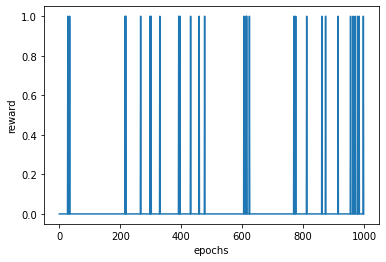

In [ ]:
plt.plot(Reward)
plt.xlabel('epochs')
plt.ylabel('reward')

In [ ]:
env = gym.make('FrozenLake8x8-v0', is_slippery=False)
env = km.wrappers.TrainMonitor(env, tensorboard_dir=tbdir)

km.enable_logging()

In [ ]:
sac_test(env, sac, num_test=1, display=False)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


INFO:TrainMonitor:ep: 4, T: 804, G: 0, avg_G: 0, t: 200, dt: 1.043ms


0.0